# `contextily`

In [1]:
%matplotlib inline

import contextily as ctx
import geopandas as gpd
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

# Data
from pysal.lib.examples import get_path

/home/serge/anaconda3/envs/pysalworkshop/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/serge/anaconda3/envs/pysalworkshop/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


`Contextily` is a package that provides functionality to work with web-tiles for background maps. 
In this notebook, we illustrate how to use `contextily` together with some of the plotting functionality in `PySAL` and `geopandas` that we have just been exposed to.

Let us first load up from `PySAL` the polygons of the 48 contiguous states using `geopandas`, and pick out Texas, for instance:

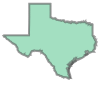

In [2]:
tx = gpd.read_file(get_path('us48.shp')).set_index('STATE_ABBR').loc[['TX'], 'geometry']
tx.crs = {'init': 'epsg:4326'}
tx['TX']

We can use this polygon to get its bounding box:

In [3]:
w, s, e, n = tx['TX'].bounds
w, s, e, n

(-106.6495132446289, 25.845197677612305, -93.50721740722656, 36.49387741088867)

## Download tiles

At this point, we can use those bounds to download the tiles for that part of the world. Before that, however, it is convenient to make sure the download will not be too heavy (i.e. not too many tiles). This is easily checked by using the `howmany` utility:

In [4]:
_ = ctx.howmany(w, s, e, n, 6, ll=True)

Using zoom level 6, this will download 9 tiles


At the zoom level 6, we need to download 9 tiles, which is not too onerous. Let us then go ahead and download them:

In [5]:
%time img, ext = ctx.bounds2img(w, s, e, n, 6, ll=True)

CPU times: user 70.2 ms, sys: 8.52 ms, total: 78.7 ms
Wall time: 559 ms


That's it! Just under three seconds and we have a map under our fingertips! Note how `bounds2img` also returns the extent that the tile covers. This will come in handy later on when we want to align it with more data.

**IMPORTANT**: the tile extent is always returned in its original CRS, the Spherical Mercator (EPSG:3857).

Let us quickly visualize it with `matplotlib`:

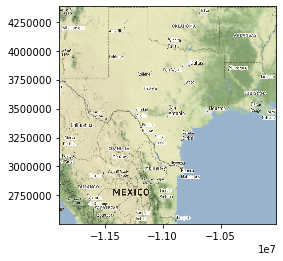

In [6]:
plt.imshow(img, extent=ext);

## Zoom Levels

Zoom level 6 is at the scale of 1:10,000,000 where each tile has a width of 5.625 degrees of longitude. This is the scale 
that is appropriate if the focus is on a large European county:

In [7]:
from IPython.display import IFrame
IFrame('https://www.texasmonthly.com/wp-content/uploads/2015/01/france.png', width=700, height=350)

At this scale, 4,096 tiles would be required to show the entire world. For more details on zoom levels see [Zoom levels at the OpenStreetMap wiki](https://wiki.openstreetmap.org/wiki/Zoom_levels).



## Save tiles into raster files

Sometimes, we know we will be working with an area for a while and it is more convenient to download the tiles only once and then load them up on-demand. To do that, we can use the function `bounds2raster`, which writes the image into a GeoTIFF raster file:

In [8]:
%time _ = ctx.bounds2raster(w, s, e, n, 6, 'tx.tif', ll=True)

CPU times: user 62.4 ms, sys: 12.7 ms, total: 75 ms
Wall time: 643 ms


## Search for tiles with text
You can also directly search for tiles using the `Place` class. This allows you to search with text. It will grab the tiles associated with that search (using GeoPy geocoding) so that you can plot them.

In [9]:
zoom=7
loc = ctx.Place("texas", zoom=zoom)

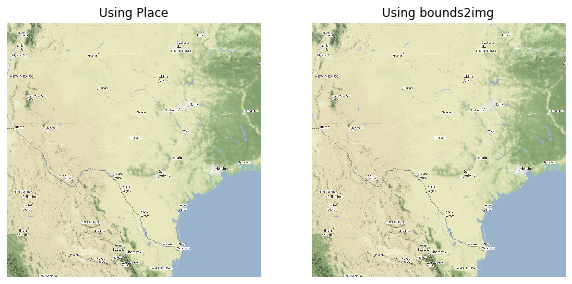

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Grab the image associated with this search and plot it
ctx.plot_map(loc.im, ax=axs[0], title='Using Place')

# Manually find this tile using the Place's bounds
zoom = ctx.calculate_zoom(loc.w, loc.s, loc.e, loc.n)
im2, bbox = ctx.bounds2img(loc.w, loc.s, loc.e, loc.n, zoom=zoom, ll=True)
ctx.plot_map(im2, bbox, ax=axs[1], title='Using bounds2img')

## Read raster tiles and combine with vector data

At this point, using the tile map is exactly the same as using any other raster file. For this, we will use the fantastic library `rasterio`. 

Let us see how we can load it back up and plot it (all of this is standard `rasterio` operations, check out its [documentation](https://mapbox.github.io/rasterio/) for more detail if interested).

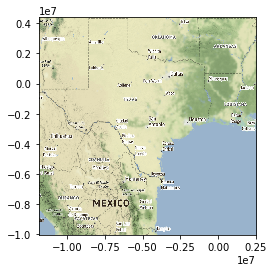

In [11]:
rtr = rio.open('tx.tif')

# NOTE the transpose of the image data
img = np.array([ band for band in rtr.read() ]).transpose(1, 2, 0)
# Plot
plt.imshow(img, extent=rtr.bounds);

## Combine layers

One of the most interesting applications of using these tiles is to employ them as basemaps to overlay additional data on top of them. This can be easily done with `matplotlib`, provided all the data are in the same CRS at the time of plotting.

Let us see how one would go about plotting the polygon for the state of Texas on top of the raster file:

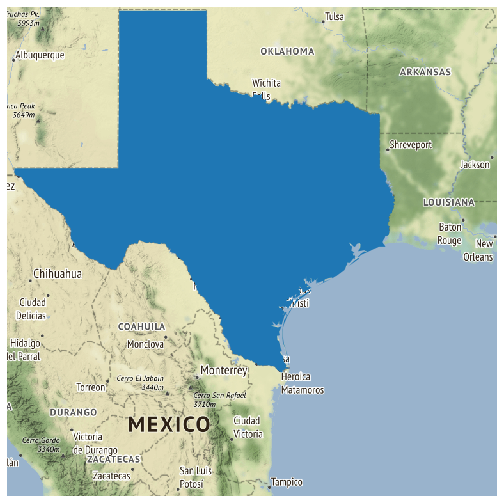

In [12]:
# Shortify the bound box named tuple
bb = rtr.bounds
# Set up the figure
f, ax = plt.subplots(1, figsize=(9, 9))
# Load the tile raster (note the re-arrangement of the bounds)
ax.imshow(img, extent=(bb.left, bb.right, bb.bottom, bb.top))
# Overlay the polygon on top (note we reproject it to the raster's CRS)
tx.to_crs(rtr.crs).plot(edgecolor='none', ax=ax)
# Remove axis for aesthetics
ax.set_axis_off()
# Show
plt.show()

## Different backgrounds

`contextily` gives access to several tile maps, all from the awesome people at [Stamen](http://stamen.com). The full list is:

In [13]:
sources = [i for i in dir(ctx.tile_providers) if i[0]!='_']
sources

['OSM_A',
 'OSM_B',
 'OSM_C',
 'ST_TERRAIN',
 'ST_TERRAIN_BACKGROUND',
 'ST_TERRAIN_LABELS',
 'ST_TERRAIN_LINES',
 'ST_TONER',
 'ST_TONER_BACKGROUND',
 'ST_TONER_HYBRID',
 'ST_TONER_LINES',
 'ST_TONER_LITE',
 'ST_WATERCOLOR']

You can set them on `bounds2img` and `bounds2raster` using the argument `url`. Checkout the documentation for more details.

Just because we can, let us get a feel for what they look like:

OSM_A
OSM_B
OSM_C


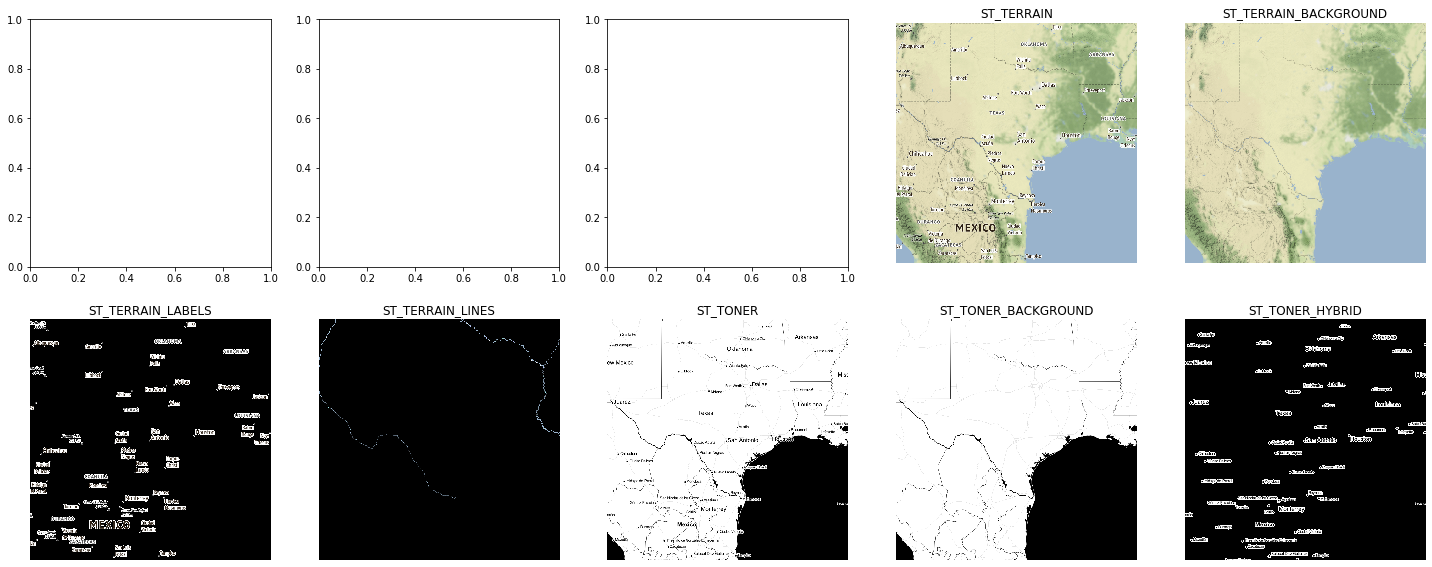

In [14]:
f, axs = plt.subplots(2, 5, figsize=(25, 10))
axs = axs.flatten()
for src, ax in zip(sources, axs):
    try:
        img, ext = ctx.bounds2img(w, s, e, n, 6, url=getattr(ctx.sources, src), ll=True)
        ax.imshow(img, extent=ext)
        ax.set_title(src)
        ax.set_axis_off()
    except:
        print(src)
plt.show()

**NOTE** Please always remember to give proper attribution to the map provider. See [here](http://maps.stamen.com/#watercolor/12/37.7706/-122.3782) for the proper way to do it, but essentially it is:

* Toner and Terrain: 

> Map tiles by <a href="http://stamen.com">Stamen Design</a>, under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>. Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://www.openstreetmap.org/copyright">ODbL</a>.

* Watercolor:

> Map tiles by <a href="http://stamen.com">Stamen Design</a>, under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>. Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://creativecommons.org/licenses/by-sa/3.0">CC BY SA</a>.

## Riverside

Let's continue on with the case of Riverside tracts that we encountered previously:

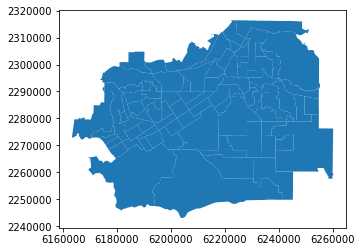

In [15]:
tracts = gpd.read_file('data/city_tracts.shp')
tracts.plot()

If you are not from Riverside, or even if you are, these tracts may not be familiar, as we lack context (pun intended).

In [16]:
tracts.crs

{'init': 'epsg:2230'}

In [17]:
tracts.total_bounds

array([6163275.54533812, 2243080.23977202, 6260291.12171774,
       2316423.63591253])

To combine these tracts together with `contextily` we first need to set the crs of the tracts to [WGS 84](https://epsg.io/4326) so that the coordinates are in lat,lon:

In [18]:
tracts = tracts.to_crs({'init': 'epsg:4326'})

In [19]:
tracts.crs

{'init': 'epsg:4326'}

In [20]:
w, s, e, n = tracts.total_bounds

In [21]:
w, s, e, n

(-117.562859, 33.81742399999976, -117.24274500000003, 34.019513999999745)

With this extent, we can then pull down tiles at zoom level 12 for Riverside. First we check
how many tiles that would require:

In [22]:
_ = ctx.howmany(w, s, e, n, 12, ll=True)

Using zoom level 12, this will download 20 tiles


Then, we request the tiles:

In [23]:
%time img, ext = ctx.bounds2img(w, s, e, n, 12, ll=True)

CPU times: user 140 ms, sys: 13.8 ms, total: 154 ms
Wall time: 1.27 s


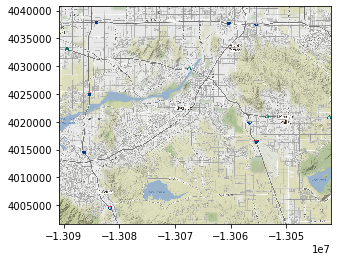

In [24]:
plt.imshow(img, extent=ext)

## Save to raster file

We save the tiles as an image for later use:


In [25]:
%time _ = ctx.bounds2raster(w, s, e, n, 12, 'rt.tif', ll=True)

CPU times: user 179 ms, sys: 12.9 ms, total: 191 ms
Wall time: 1.34 s


Reading the image in and layering the tracts on top of the image:

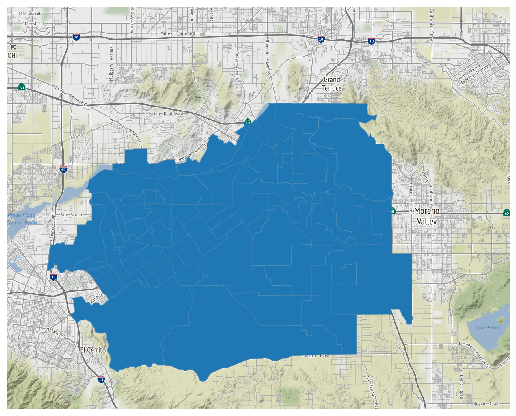

In [26]:
rt = rio.open('rt.tif')


# Shortify the bound box named tuple
bb = rt.bounds
# Set up the figure
f, ax = plt.subplots(1, figsize=(9, 9))
# Load the tile raster (note the re-arrangement of the bounds)
ax.imshow(img, extent=(bb.left, bb.right, bb.bottom, bb.top))
# Overlay the polygon on top (note we reproject it to the raster's CRS)
tracts.to_crs(rtr.crs).plot(edgecolor='none', ax=ax)
# Remove axis for aesthetics
ax.set_axis_off()
# Show
plt.show()

We see the context around the extent, but the tracts are opaque and obscure the internal context for Riverside.
We can correct this using the `alpha` parameter in the call to the dataframe plot:

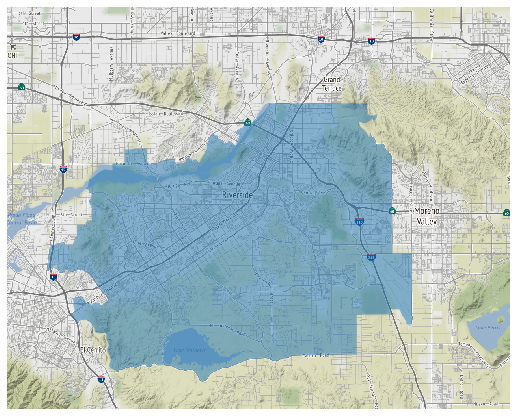

In [27]:


# Shortify the bound box named tuple
bb = rt.bounds
# Set up the figure
f, ax = plt.subplots(1, figsize=(9, 9))
# Load the tile raster (note the re-arrangement of the bounds)
ax.imshow(img, extent=(bb.left, bb.right, bb.bottom, bb.top))
# Overlay the polygon on top (note we reproject it to the raster's CRS)
tracts.to_crs(rtr.crs).plot(edgecolor='none', ax=ax, alpha=0.5)
# Remove axis for aesthetics
ax.set_axis_off()
# Show
plt.show()

In a future version of `contextily` there will be functionally that simplifies this.
The code is as follows:

In [28]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

and we reproject the tracts to [Web Mercator (EPSG 3857)](https://epsg.io/3857):

In [29]:
tracts = tracts.to_crs(epsg=3857)

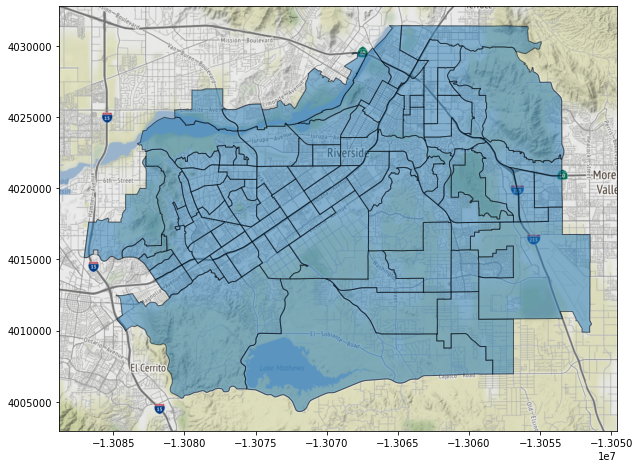

In [30]:
ax = tracts.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
add_basemap(ax, zoom=12)


---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-
sa/4.0/"><img alt="Creative Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span
xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Contextily</span> by <a xmlns:cc="http://creativecommons.org/ns#"
href="http://sergerey.org" property="cc:attributionName"
rel="cc:attributionURL">Serge Rey</a> is licensed under a <a
rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative
Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Some of this material was adopted from examples in the [contextily 0.99 user guide](https://github.com/darribas/contextily/blob/917b723e87dca831b2efd7eb64e8decc5675e8cf/contextily_guide.ipynb).
